<a href="https://colab.research.google.com/github/leeaain2027/AIFFEL_quest_eng/blob/main/Computer_Vision/CV02/260209_CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아웃 포커싱 인물사진 만들기  
- 셸로우 포커스 만들기
### 학습 내용  
(1) 사진 준비  
(2) 세그멘테이션으로 사람 분리하기  
(3) 시맨틱 세그멘테이션(DeepLab)  
- 피사체(사람)와 배경 분리  
(4) 배경 흐리게 하기
- 블러링 기술  
(5) 흐린 배경과 원본 영상 합성  
- 피사체를 배경의 원래 위치에 합성
---

# 학습노드  
프로젝트는 후반부에 있음.

### 세그멘테이션(image segmentation)을 위한 준비
세그멘테이션 기술을 이용, 하나의 이미지에서 배경과 사람을 분리

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 현재 작업 디렉토리 하위에 폴더 만들기
!mkdir -p ./models
!mkdir -p ./images

Mounted at /content/drive
cp: cannot stat 'drive/MyDrive/Aiffel/week7/man.png': No such file or directory


In [ ]:
# 내 구글 드라이브에서 필요한 이미지 복사해오기
# 남자 인물사진 이미지
!cp drive/MyDrive/Aiffel/week7/images/man.png ./images

In [ ]:
# opencv-python: 이미지나 영상을 읽고, 쓰고, 편집하는 모든 기초 작업을 담당
# pixellib: 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
#           이미지 속의 물체를 정밀하게 분리해내는 '인스턴스 분할(Instance Segmentation)'에 특화
! pip install opencv-python pixellib

# 런타임 재시작필요 -> 설치한 패키지는 시스템에 저장되어 있어 날아가지 않음.

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.3/430.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 2.8 MB/s eta 0:00:00
   

In [ ]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
#
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


In [ ]:
# 이미지 준비 - 다운로드
! wget https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png

--2026-02-09 03:43:22--  https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.170.152.18, 3.170.152.52, 3.170.152.88, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.170.152.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662087 (647K) [image/png]
Saving to: ‘E-14-3.max-800x600_KwXP73b.png’

E-14-3.max-800x600_ 100%[===================>] 646.57K   965KB/s    in 0.7s    

2026-02-09 03:43:23 (965 KB/s) - ‘E-14-3.max-800x600_KwXP73b.png’ saved [662087/662087]



이미지 크기: (450, 800, 3)


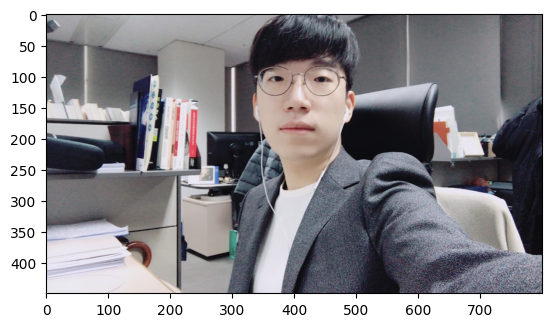

In [ ]:
# home_dir = os.getenv('HOME')
# img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")

img_path = "images/man.png"
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기  
사람과 배경을 분리하기

DeepLab 모델 준비.  
Pascal VOC라는 데이터셋의 기준에 맞춰 학습되었기 때문에,  
사물 클래스 20개, 배경 클래스 1개 총 21개의 클래스를 가지고 있음.

In [ ]:
# DeepLab 모델 다운로드
model = deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:03<00:00, 62.4MB/s]


사용할 이미지 전처리 -> 사전학습된 모델의 전처리 방식과 입력 크기가 동일해야 함.

In [ ]:
# 이미지 전처리 객체 선언
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [ ]:
# 앞서 정의한 전처리 객체를 활용해서 이미지 전처리하기
input_tensor = \
    transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [ ]:
# 모델에 이미지 입력하기
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(
        output_predictions,
        (
            img_orig.shape[1],
            img_orig.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

CPU times: user 12 s, sys: 653 ms, total: 12.7 s
Wall time: 14.3 s


output_predictions에 담겨있는 데이터 형태는 어떤건지 확인해보자.

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]]


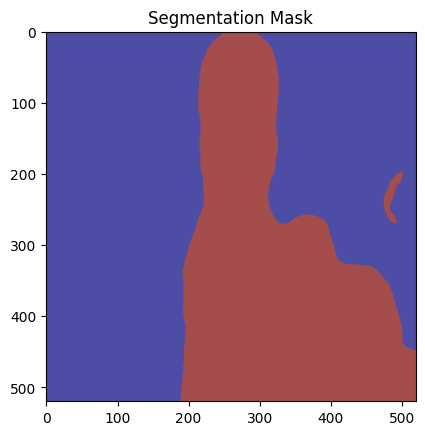

In [ ]:
print(output_predictions)

plt.imshow(output_predictions, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask")
plt.show()

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]]


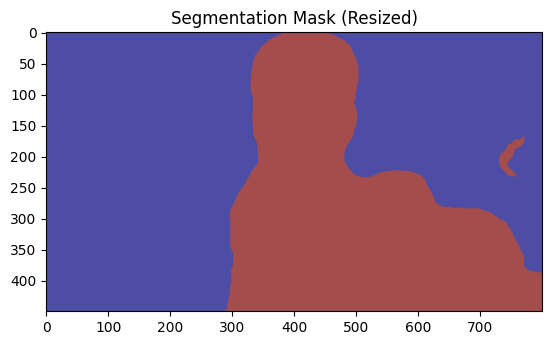

In [ ]:
print(output_predictions_resized)

plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [ ]:
# pascalvoc 데이터의 라벨종류
# output_predictions_resized의 각 픽셀 자리에 아래의 클래스 번호(ID)가 적혀 있음.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

🧐 위에서 확인한 라벨들이 검출되었는지 알아보기

In [ ]:
for idx, label in enumerate(LABEL_NAMES):
    exists = "있음" if np.any(output_predictions_resized == idx) else "--"
    print(f"{label}: {exists}")

background: 있음
aeroplane: --
bicycle: --
bird: --
boat: --
bottle: --
bus: --
car: --
cat: --
chair: --
cow: --
diningtable: --
dog: --
horse: --
motorbike: --
person: 있음
pottedplant: --
sheep: --
sofa: --
train: --
tv: --


세그멘테이션 된 결과가 어떤 것들이 있는지 확인.
- output_predictions_resized: 숫자로 가득 찬 격자판  
  사람이 있는 픽셀들에는 전부 15가 적혀 있음.
  기본적으로는 0이 들어가며, 이는 인식된 객체 이외는 전부 background(0)로 처리하는 결과가 됨.

In [ ]:
# np.unique: 배열 안에 있는 값들 중 중복을 제거하고 유일한 값들만 정렬해서 보여줌.
unique_classes = np.unique(output_predictions_resized)
unique_classes    # 사진에 등장하는 사물들의 번호 리스트

for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


물체마다 output에 어떤 색상으로 나타나 있는지 알아내기

In [ ]:
# DeepLab이 사용한 컬러맵 만들기
# PixelLib에서 그대로 가져온 코드입니다
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

위 컬러맵으로 사람만 표시된 마스크 만들기

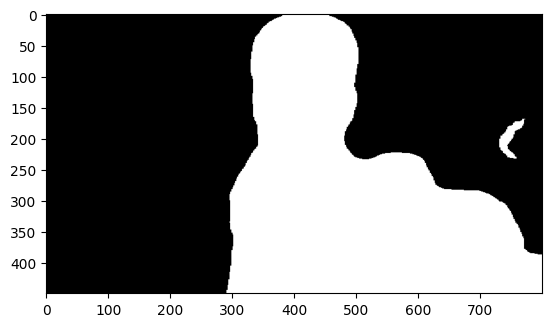

In [ ]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환 -> 컨트라스트 극대화
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

🧐 이미지를 가져오는 부분이 없는데 어떻게 오리지널 이미지대로 마스크를 그렸지?  
-> `output_predictions_resized`가 넘파이 배열이라서 자동으로 배열 내 모든 요소를 꺼내서 비교연산 후 True,False로 채워진 동일한 크기의 배열을 반환함.

In [ ]:
print(output_predictions_resized.shape)
print(type(output_predictions_resized))
print(color_mask.shape)
print(type(color_mask))
print()
print(seg_map)

(450, 800)
<class 'numpy.ndarray'>
(450, 800, 3)
<class 'numpy.ndarray'>

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


---
생성한 컬러마스크를 원래 이미지와 겹쳐 보여주기

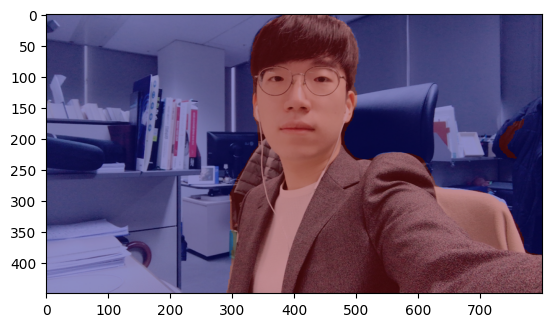

In [ ]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

배경을 흐리게 만들기

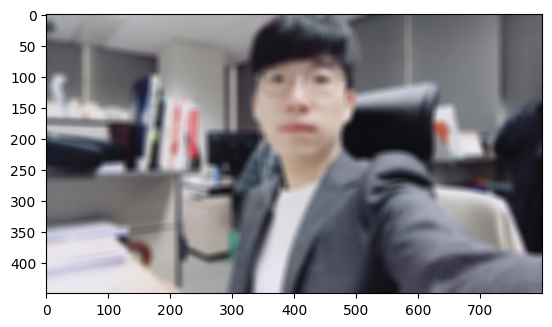

In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

blurring kernel size를 조정해보자.  
! 이 크기에 따라 블러의 정도가 달라진다.

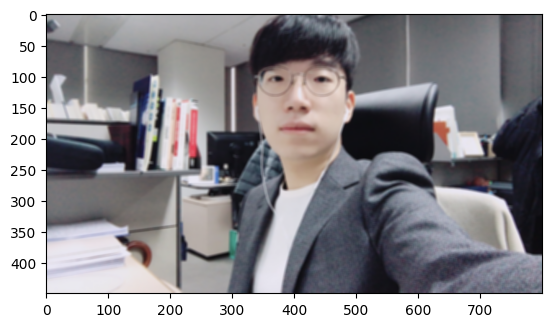

In [ ]:
img_orig_blur2 = cv2.blur(img_orig, (5, 5))
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

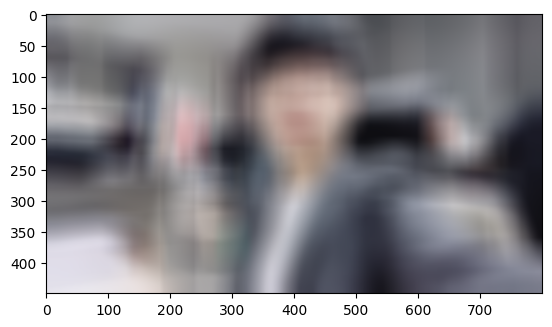

In [ ]:
img_orig_blur2 = cv2.blur(img_orig, (55, 55))
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 추출  
흐려진 이미지에서 세그멘테이션 마스크 이용

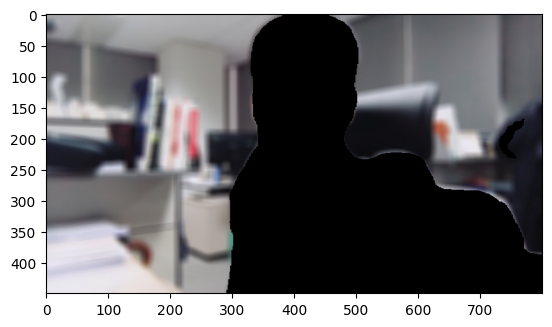

In [ ]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: BGR 형식을 RGB 형식으로 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

블러된 배경과 인물 합성

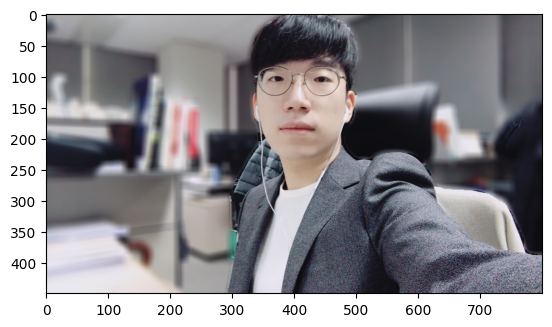

In [ ]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값 가지고 오기
# 아닌 영역: 블러된 이미지 값
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: BGR 형식을 RGB 형식으로 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

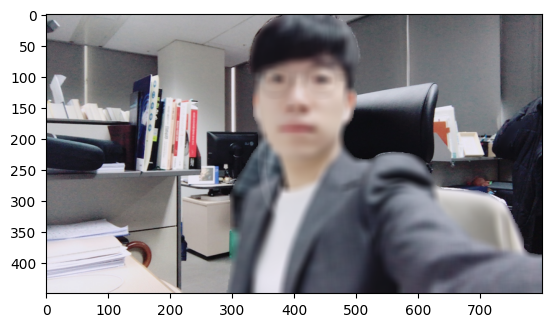

In [ ]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

🧐- BGR로 읽어오는 특별한 이유가 있나?  
-> 90년대 윈도우 표준(BGR)을 따랐던 흔적. 지금와서 바꾸면 전세계의 CV 코드가 영향을 받기 때문에 못바꾼 것.  

- 매번 `cv2.cvtColor`해주지 않고 처음부터 해놓으면 안되는 걸까?   
-> openCV의 함수들이 내부적으로 BGR순서가 표준이기 때문에 간혹 문제가 생길 수 있다고 함.
  - 색맹함수, 색인지 함수들의 작동 차이
  - 협업과 유지보수 문제 (다른 개발자나 인터넷의 수많은 예제코드들은 BGR을 전제로 함)


---
# 프로젝트 02


In [ ]:
# 이미지 준비
!cp drive/MyDrive/Aiffel/week7/images/woman_tv_sofa.png ./images
!cp drive/MyDrive/Aiffel/week7/images/cat.jpg ./images
!cp drive/MyDrive/Aiffel/week7/images/sand.jpg ./images

원본 고양이 이미지 크기: (528, 640, 3)
배경(사막) 이미지 크기: (360, 640, 3)


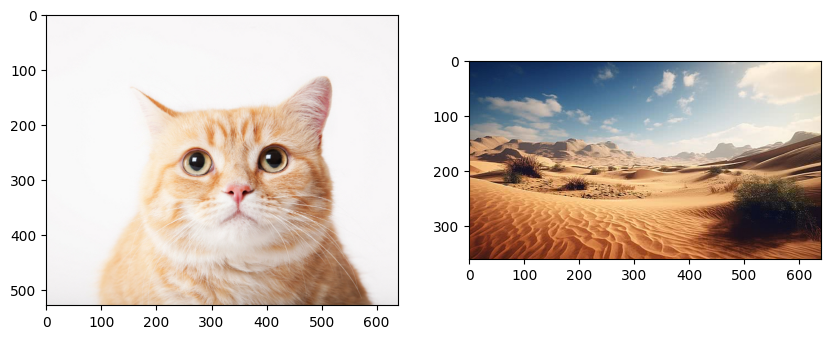

In [ ]:
cat_img_path = "images/cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "images/sand.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

모델에 이미지 입력 & 분석표(마스크) 받기

In [ ]:
# 사전학습된 ResNet101 기반 DeepLabV3 모델 로드 및 추론(평가) 모드로 설정
model = deeplabv3_resnet101(pretrained=True).eval()

# 이미지 전처리를 위한 변환 파이프라인 정의
transform = T.Compose([
    T.ToPILImage(),        # 이미지를 PIL 이미지 형식으로 변환
    T.Resize((520, 520)),  # 모델 입력 규격에 맞게 이미지 크기 조정
    T.ToTensor(),          # 픽셀 값을 0~1로 정규화하고 PyTorch 텐서로 변환
])

# 전처리 적용 후 모델 입력을 위한 배치 차원 추가 (C, H, W) -> (1, C, H, W)
input_tensor = transform(cat_img).unsqueeze(0)

# 가중치 업데이트(기울기 계산)를 비활성화하여 메모리 절약 및 속도 향상
with torch.no_grad():
    # 모델 추론 수행 후 출력 딕셔너리에서 'out' 결과물의 첫 번째 배치 추출
    output = model(input_tensor)["out"][0]
    # 채널 축(0번 축)을 따라 최대 확률을 가진 클래스 인덱스를 추출하고 NumPy 배열로 변환
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 리사이즈 전 단계의 추론 마스크 크기 출력
print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [ ]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (528, 640)


In [ ]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


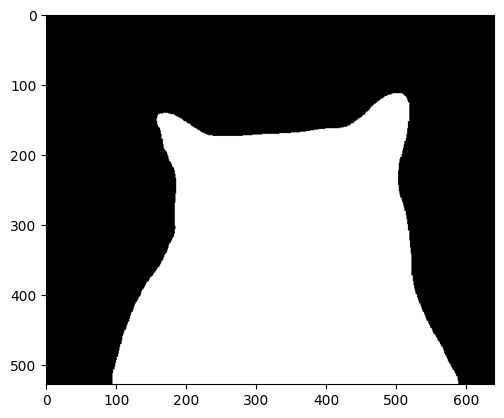

In [ ]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

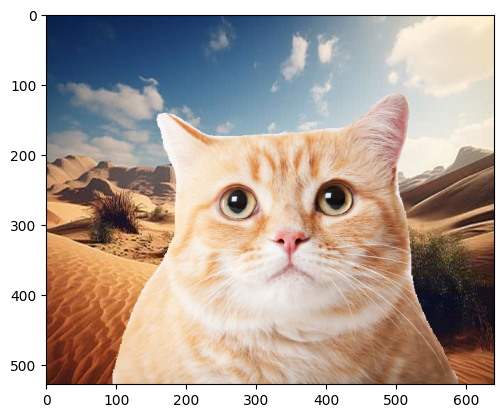

In [ ]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

## Step2. 사진에서 문제점 찾기


### 뒷배경의 점퍼까지 사람으로 인식되는 문제점  
해결책  
1. 모델 변경
-> COCO 데이터셋(80종)으로 학습한 모델로 변경.

2. Meta의 Segment Anything Model, SAM으로 변경.  
-> 라벨 리스트에 없는 물체라도 형태를 이해해서 경계를 따줌. DeepLab으로 대략적인 '사람' 위치를 잡고, 그 좌표를 SAM에게 전달.

3. 모델은 그대로 두고 결과물만 다듬기.  
- CRF: 세그멘테이션 결과의 픽셀 간 연관성을 계산. 색상이 급격히 변하는 부분을 경계선으로 하고 마스크를 밀어넣거나 당겨주는 전통적인 기법
- GrabCut: OpenCV가 제공하는 기능. 마스크를 가이드 삼아 실제 이미지의 색상차를 분석해 경계를 다시 계산.

### 1. COCO 데이터셋 모델 사용  
DeepLabV3 대신 Mask R-CNN 모델.  
인스턴스 세그멘테이션 모델로, 80개의 사물 인식이 가능.

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# COCO 80종을 인식하는 최신 가중치(Weights)와 모델 로드
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights).eval()

# 이 모델이 인식하는 80개의 클래스 목록 확인 (0번 배경 포함 91개 중 80개 사용)
coco_labels = weights.meta["categories"]
print(f"인식 가능한 사물 개수: {len(coco_labels)}")
for i in range(0,len(coco_labels),10):
    print(coco_labels[i:i+10])

인식 가능한 사물 개수: 91
['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']
['traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse']
['sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A']
['N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat']
['baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife']
['spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza']
['donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A']
['toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven']
['toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier']
['toothbrush']


해당 모델에 사전학습된 이미지 크기로 리사이징

In [ ]:
# 이미지 전처리 객체 선언
transform_maskrcnn = T.Compose([
    T.ToPILImage(),
    T.Resize((800, 800)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

# 앞서 정의한 전처리 객체를 활용해서 이미지 전처리하기
input_tensor_maskrcnn = \
    transform_maskrcnn(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

COCO 데이터셋 모델은 사람 ID가 15번이 아니라 1번.  
전체 사물은 0.5 정도로 넉넉하게 보되, '사람'만 0.9라는 엄격한 기준을 적용하기.

In [ ]:
# 모델에 이미지 입력하기
%%time
# with torch.no_grad():
#     output = model(input_tensor)["out"][0]
#     output_predictions = output.argmax(0).byte().cpu().numpy()

with torch.no_grad():
    # 1. 모델 추론 (결과는 리스트 형태)
    outputs = model(input_tensor_maskrcnn)

    # 2. 첫 번째 이미지의 결과 딕셔너리 추출
    output_dict = outputs[0]

    # 3. 데이터 추출 (마스크, 라벨, 신뢰도 점수)
    masks = output_dict['masks']   # shape: [물체개수, 1, H, W]
    labels = output_dict['labels'] # 각 물체의 클래스 ID
    scores = output_dict['scores'] # 각 물체의 신뢰도 (0~1)

# 여러 개의 마스크를 하나의 '격자판(Semantic Map)'으로 합치기
# 빈 배경(0)으로 채워진 도화지 준비
h, w = masks.shape[2], masks.shape[3]
semantic_map = semantic_map2 = np.zeros((h, w), dtype=np.uint8)

# 신뢰도가 높은(예: 0.5 이상) 물체들만 루프를 돌며 도화지에 번호 적기
# 1번 semantic_map: 0.5이상만 적용
for i in range(len(masks)):
    if scores[i] > 0.5:
        mask = masks[i, 0].cpu().numpy()
        label = labels[i].item()

        # 마스크가 True(0.5 초과)인 영역에 해당 클래스 번호를 채움
        semantic_map2[mask > 0.5] = label


# 2번 semantic_map: 0.5이상으로 식별해서 그 중 person이라면 0.9를 적용해서 더 까다롭게 봄.
for i in range(len(masks)):
    score = scores[i].item()  # 해당 물체의 전체 신뢰도 점수
    label = labels[i].item()  # 해당 물체의 클래스 ID
    mask = masks[i, 0].cpu().numpy() # 해당 물체의 픽셀별 확률 마스크

    if label == 1: # 1. 만약 사물이 '사람'이라면?
        if score > 0.9: # 2. 전체 신뢰도가 0.9 이상일 때만 통과
            # 여기서 0.5를 더 높이면(예: 0.8) 사람의 경계선이 더 안쪽으로 타이트하게 잡힙니다.
            semantic_map[mask > 0.5] = label
            print(f"✅ 사람 발견! 신뢰도: {score:.4f}")
    else: # 3. 사람이 아닌 다른 사물들이라면?
        if score > 0.5: # 기존처럼 0.5 기준으로 추출
            semantic_map[mask > 0.5] = label


# 원본 크기로 Resize
output_maskrcnn_predictions_resized = cv2.resize(
        semantic_map,
        (
            img_orig.shape[1],
            img_orig.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

output_maskrcnn_predictions_resized2 = cv2.resize(
        semantic_map2,
        (
            img_orig.shape[1],
            img_orig.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

✅ 사람 발견! 신뢰도: 0.9964
CPU times: user 8.16 s, sys: 571 ms, total: 8.73 s
Wall time: 8.89 s


In [ ]:
# np.unique: 배열 안에 있는 값들 중 중복을 제거하고 유일한 값들만 정렬해서 보여줌.
unique_classes_maskrcnn = np.unique(output_maskrcnn_predictions_resized)
unique_classes_maskrcnn    # 사진에 등장하는 사물들의 번호 리스트

for class_id in unique_classes_maskrcnn:
    print(f"ID {class_id}: {coco_labels[class_id]}")

ID 0: __background__
ID 1: person
ID 62: chair
ID 84: book


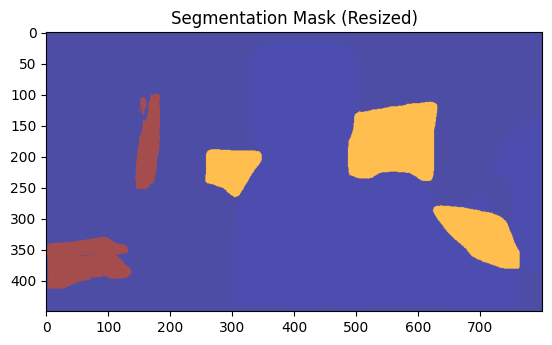

In [ ]:
plt.imshow(output_maskrcnn_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [ ]:
# 1. COCO의 최대 ID(91)를 수용할 수 있도록 넉넉하게 92개 이상의 색상 생성
def get_safe_coco_colormap(max_id=100): # 100개 정도로 넉넉하게 설정
    np.random.seed(42)
    # 배경 포함 100개의 랜덤 색상 생성
    colormap = np.random.randint(0, 256, size=(max_id, 3), dtype=np.uint8)
    # 0번(배경)은 확실하게 검은색으로 고정
    colormap[0] = [0, 0, 0]
    return colormap

# 안전한 컬러맵 다시 생성
coco_colormap = get_safe_coco_colormap()

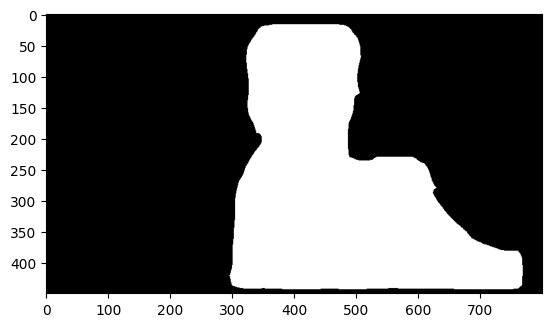

In [ ]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_maskrcnn_predictions_resized == 1)  # 클래스 ID 1 (사람)

# Boolean 배열(True/False)을 8비트 정수형(0~255)으로 변환
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환 -> 컨트라스트 극대화

# JET 컬러맵을 적용하면 흰색이었던 영역이 붉은색 계열로 변함
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

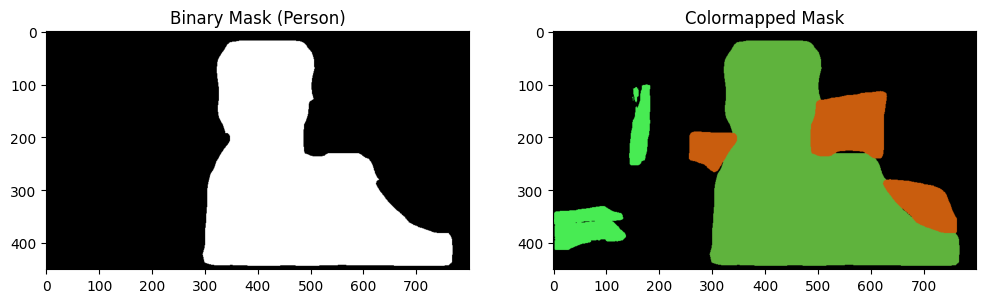

In [ ]:
# 4. 결과 출력
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_mask, cmap='gray')
plt.title("Binary Mask (Person)")

colored_mask = coco_colormap[output_maskrcnn_predictions_resized]
plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.title("Colormapped Mask")

plt.show()

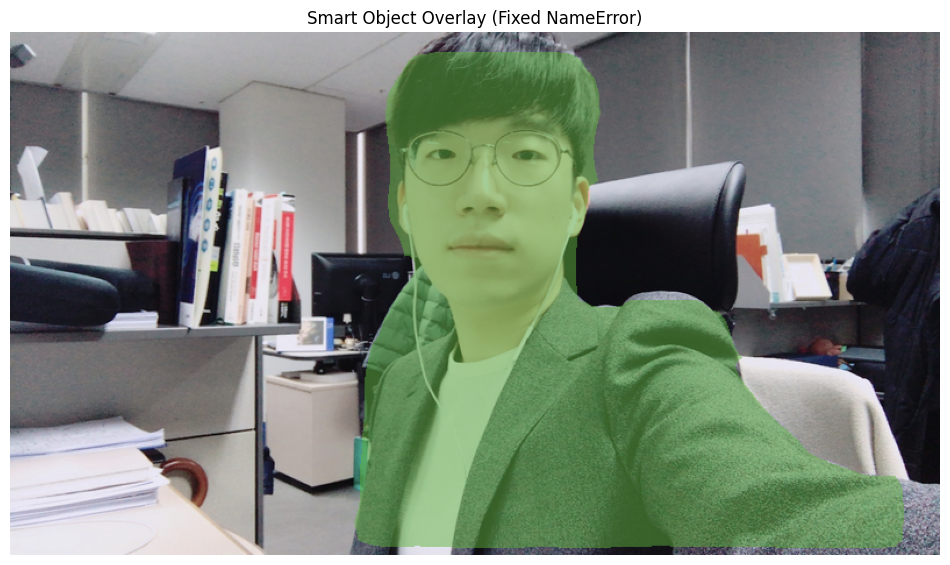

In [ ]:
# 원본 이미지를 RGB로 변환 (재료 1)
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
colored_mask = coco_colormap[output_maskrcnn_predictions_resized]

alpha = 0.5  # 투명도 설정
overlay_rgb = cv2.addWeighted(img_orig_rgb, alpha, colored_mask, 1 - alpha, 0)

is_person = (output_maskrcnn_predictions_resized == 1)
is_person_3d = is_person[..., None] # 차원 확장 (H, W) -> (H, W, 1)

# 스마트 합성 (np.where)
# 사물이면 섞인 이미지(overlay_rgb), 배경이면 생 원본(img_orig_rgb) 사용
smart_overlay = np.where(is_person_3d, overlay_rgb, img_orig_rgb)

# 6. 최종 결과 출력
plt.figure(figsize=(12, 8))
plt.imshow(smart_overlay)
plt.title("Smart Object Overlay (Fixed NameError)")
plt.axis('off')
plt.show()

시멘틱 마스크2 (person > 0.9)

# 회고  
---
### 아쉬운 점
1. 문서 작성이 깔끔하지 못함. 가독성과 정리에 좀 더 중점을 두고 프로젝트 마감 시간 30분전에는 문서를 다듬는 시간을 필히 가져야겠다.
2. 코드를 병합하고 깔끔하게 주석을 달 것. 지금은 코드가 단계별 셀로 분할되어 있는데 완성하고 난 뒤에는 하나의 셀로 병합해두는 것이 보기 좋겠다.
3. 시간 내에 마무리하지 못했다. Git설정 등을 다시 만지고 파악하느라 엉뚱하게 보낸 시간이 많았다. 좀 더 집중해서 과제를 처리하자.
### 잘했다고 생각하는 점
1. 문제(점퍼가 사람으로 인식되는)를 해결해보려고 여러 방법을 찾아보고 실제로 시도해보았다.
### 더 공부해볼 부분
1. 마스킹이 계단식으로 나타나는 부분을 어떻게 해결할 수 있을까?
  예를 들어 고양이 털을 세밀하게 마스킹하고 싶을 때
2. 리사이징은 마스킹에 어떤 영향을 미칠까?
  이미지를 축소했다가 다시 확대하면 어떻게 될까?  
3. 찾아본 해결책들 중에서 어떤 것들이 전이학습, 제로샷 학습일까?
   


In [ ]:
plt.imshow(output_maskrcnn_predictions_resized2, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

